In [1]:
import numpy as np
import scipy.linalg
import scipy.stats
import scipy.special
import torch
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
case = 'samples'
burnin = 500
alpha = 0.05

exec(open('./data_gen.py').read())
exec(open('./prior_settings.py').read())

In [3]:
# read result
z_store = np.empty( shape = (maxiter, m, p2))
beta_store = np.empty( shape = (maxiter, p2, q))
tau_store = np.empty( shape = (maxiter, p2, q))
gamma_store = np.empty( shape = (maxiter, q))
pi_store = np.empty( shape = (maxiter, q))
sigmae_store = np.empty( shape = (maxiter, 1))

for iter in tqdm(range(maxiter)):
    z_store[iter,:,:] = np.load('./'+case+ '/z_store/tem_z_'+str(iter)+'.npy')
    beta_store[iter,:,:] = np.load('./'+case+ '/beta_store/tem_beta_'+str(iter)+'.npy')
    tau_store[iter,:,:] = np.load('./'+case+ '/tau_store/tem_tau_'+str(iter)+'.npy')
    gamma_store[iter,:] = np.load('./'+case+ '/gamma_store/tem_gamma_'+str(iter)+'.npy')
    pi_store[iter,:] = np.load('./'+case+ '/pi_store/tem_pi_'+str(iter)+'.npy')
    sigmae_store[iter,:] = np.load('./'+case+ '/sigmae_store/tem_sigmae_'+str(iter)+'.npy')
    
# save for fast load
np.save( './npys_store/z_store.npy', z_store)
np.save( './npys_store/beta_store.npy', beta_store)
np.save( './npys_store/tau_store.npy', tau_store)
np.save( './npys_store/gamma_store.npy', gamma_store)
np.save( './npys_store/pi_store.npy', pi_store)
np.save( './npys_store/sigmae_store.npy', sigmae_store)

100%|██████████| 2000/2000 [00:39<00:00, 50.55it/s]


In [4]:
# fast load
z_store = np.load( './npys_store/z_store.npy' )
beta_store = np.load( './npys_store/beta_store.npy' )
tau_store = np.load( './npys_store/tau_store.npy' )
gamma_store = np.load( './npys_store/gamma_store.npy' )
pi_store = np.load( './npys_store/pi_store.npy' )
sigmae_store = np.load( './npys_store/sigmae_store.npy' )

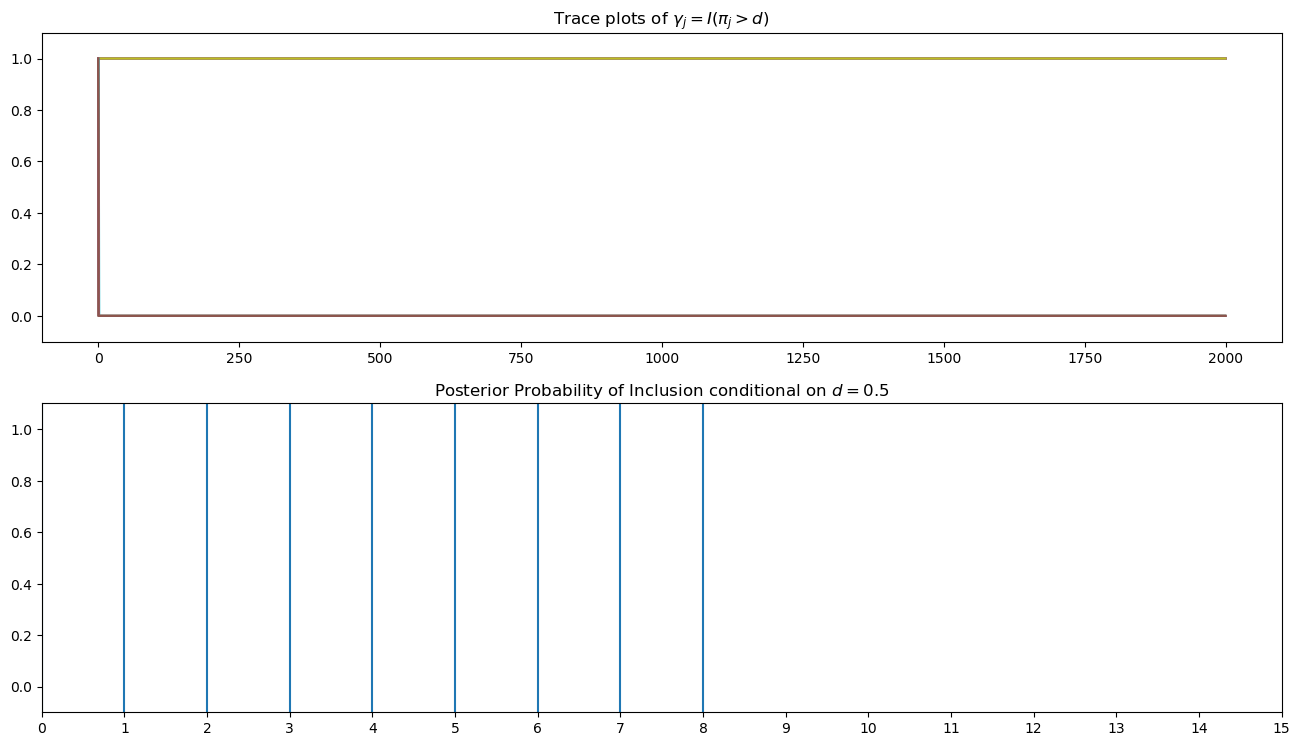

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [5]:
# Gamma plot
fig, axs = plt.subplots(2,1, figsize = (16,9), dpi = 100)

axs[0].set_title(r'Trace plots of $\gamma_j = I(\pi_j>d)$' )
axs[0].set_ylim([-0.1,1.1])

for j in range(q):
    axs[0].plot( gamma_store[:,j])
    
axs[1].set_title(r'Posterior Probability of Inclusion conditional on $d = 0.5$' )
axs[1].set_ylim([-0.1,1.1])
axs[1].set_xticks( list(range(q)))
for j in range(q):
    axs[1].axvline( j, ymin = 0, ymax = np.mean(gamma_store[burnin:maxiter,j]))
plt.show()

# est gamma 
est_gamma = np.empty( q )
est_gamma = (gamma_store[burnin:maxiter,].mean(axis = 0) > 0.5 ) * 1

np.row_stack( [ (tau.sum(axis = 0) != 0),gamma_store[burnin:maxiter,:,].mean(axis = 0)] ).round(2)

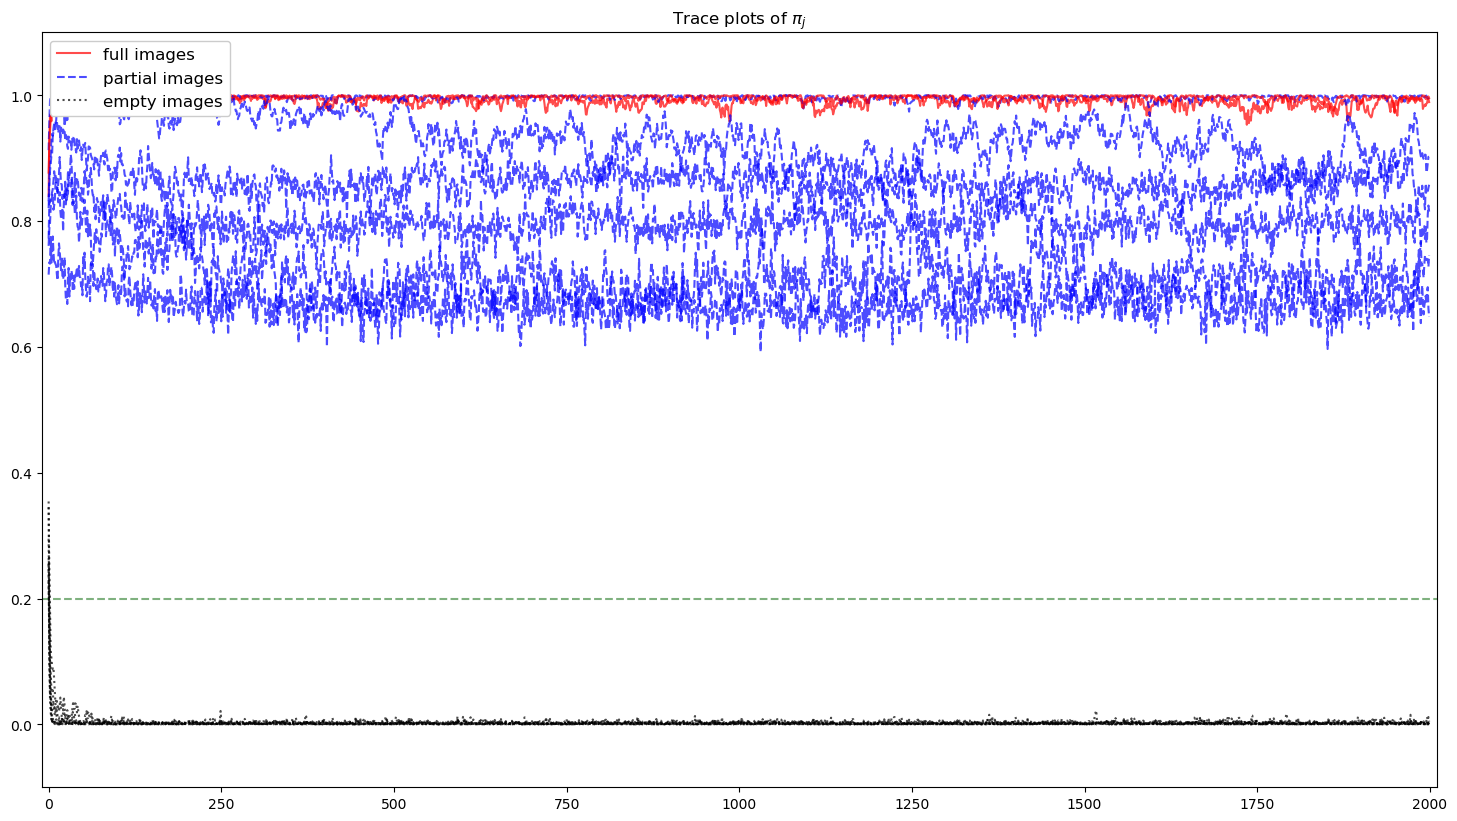

In [7]:
# pi plot
%matplotlib inline
fig, axs = plt.subplots(1,1, figsize = (18,10), dpi = 100)

axs.set_title(r'Trace plots of $\pi_j$' )
axs.set_ylim([-0.1,1.1])
axs.set_xlim([-10,(maxiter+10)])
axs.axhline( y = 0.2 ,color = 'darkgreen', linestyle = '--', alpha = 0.5)

for j in range(1,q):
    if (j == 1) | ( j == 6):
        line_type = '-'
        line_color = 'red'
        line_alpha = 0.7
    if (j in range(1,9)) &  (j != 1) & ( j != 6) :
        line_type = '--'
        line_color = 'blue'
        line_alpha = 0.7
    if (j in range(9,q)):
        line_type = ':'
        line_color = 'black'
        line_alpha = 0.7
    if ( j == 1 ):
        line_label = 'full images'
        axs.plot( pi_store[:,j], linestyle = line_type, color = line_color, alpha = line_alpha, label = line_label)
    elif ( j == 2 ):
        line_label = 'partial images'
        axs.plot( pi_store[:,j], linestyle = line_type, color = line_color, alpha = line_alpha, label = line_label)
    elif ( j == 9 ):
        line_label = 'empty images'
        axs.plot( pi_store[:,j], linestyle = line_type, color = line_color, alpha = line_alpha, label = line_label)
    else:
        axs.plot( pi_store[:,j], linestyle = line_type, color = line_color, alpha = line_alpha)

axs.legend( loc = 'upper left', framealpha = 1, fontsize = "large")
    

In [12]:
# tau select
tau_ppi = np.empty( (p2,q) )
for j in range(q):
    if est_gamma[j] == 0:
        tau_ppi[:,j] = 0
    else:
        tau_ppi[:,j] = (beta_store[burnin:maxiter,:,j] != 0).mean(axis = 0)

est_tau = np.empty( (p2,q) )

TP = np.empty( (q))
FN = np.empty( (q))
TN = np.empty( (q))
FP = np.empty( (q))

TPR = np.empty( (q))
FNR = np.empty( (q))
TNR = np.empty( (q))
FPR = np.empty( (q))

Mprecision = np.empty( (q) )
Mrecall = np.empty( (q) )
MF1 = np.empty( (q) )

est_tau = np.empty( (p2,q) )

for j in range(q):
    if est_gamma[j] == 0:
        est_tau[:,j] = 0
        TP[j] = np.sum( np.isin( np.where( est_tau[:,j] == 1 ) , np.where( tau[:,j] == 1) ) )
        FN[j] = np.sum( np.isin( np.where( est_tau[:,j] == 0 ) , np.where( tau[:,j] == 1) ) )
        TN[j] = np.sum( np.isin( np.where( est_tau[:,j] == 0 ) , np.where( tau[:,j] == 0) ) )
        FP[j] = np.sum( np.isin( np.where( est_tau[:,j] == 1 ) , np.where( tau[:,j] == 0) ) )
        
        TPR[j] = TP[j]/np.sum(tau[:,j] == 1)
        TNR[j] = TN[j]/np.sum(tau[:,j] == 0)
        FPR[j] = FP[j]/np.sum(tau[:,j] == 0)
        FNR[j] = FN[j]/np.sum(tau[:,j] == 1)
    else:
        est_tau[:,j] =  ( np.quantile( beta_store[burnin:maxiter,:,j], 0.5, axis = 0) != 0) * 1

        TP[j] = np.sum( np.isin( np.where( est_tau[:,j] == 1 ) , np.where( tau[:,j] == 1) ) )
        FN[j] = np.sum( np.isin( np.where( est_tau[:,j] == 0 ) , np.where( tau[:,j] == 1) ) )
        TN[j] = np.sum( np.isin( np.where( est_tau[:,j] == 0 ) , np.where( tau[:,j] == 0) ) )
        FP[j] = np.sum( np.isin( np.where( est_tau[:,j] == 1 ) , np.where( tau[:,j] == 0) ) )
        
        TPR[j] = TP[j]/np.sum(tau[:,j] == 1)
        TNR[j] = TN[j]/np.sum(tau[:,j] == 0)
        FPR[j] = FP[j]/np.sum(tau[:,j] == 0)
        FNR[j] = FN[j]/np.sum(tau[:,j] == 1)
        
MFDR = FP/(FP+TP)
Mprecision = TP/(TP+FP)
Mrecall = TP/(TP+FN)
MF1 = Mprecision*Mrecall*2/(Mprecision+Mrecall)

/opt2/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/opt2/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars
/opt2/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
/opt2/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/opt2/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/opt2/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/opt2/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value enco

In [15]:
# scores for median model
np.row_stack( [Mprecision, Mrecall, MF1] )[:,1:9].round(3)

array([[1.   , 0.902, 0.959, 0.967, 0.975, 1.   , 0.936, 0.905],
       [0.994, 1.   , 0.964, 0.981, 0.935, 1.   , 0.942, 0.692],
       [0.997, 0.948, 0.961, 0.974, 0.955, 1.   , 0.939, 0.784]])

In [21]:
# beta estimate
est_beta = np.empty( (p2,q) )
for j in range(q):
    if est_gamma[j] == 0:
        est_beta[:,j] = 0
    else:
        est_beta[:,j] = ((beta_store[burnin:maxiter,:,j].sum(axis = 0))/((beta_store[burnin:maxiter,:,j]!=0).sum(axis = 0)))
        
est_beta = est_beta * est_tau

In [28]:
# cov matrix fast load and save
Sigma_store = np.empty( shape = (maxiter,p2,p2))
for iter in range(maxiter):
    Sigma_store[iter,:,:] =  np.load('./'+case+ '/Sigma_store/tem_Sigma_'+str(iter)+'.npy')

est_Sigma = Sigma_store[burnin:maxiter,:,:].mean(axis = 0)
np.save( './npys_store/Sigma_store.npy', Sigma_store)

In [29]:
# mean surface and cov surface
est_z = z_store[burnin:maxiter,:].mean(axis = 0)
error_bz = np.mean( (est_z - Z)** 2)

Sigma_store = np.load( './npys_store/Sigma_store.npy')
est_Sigma = Sigma_store[burnin:maxiter,:,:].mean(axis = 0)

error_bs = np.mean( (est_Sigma - Sigma_eta) ** 2 )


MSE = np.array( [error_bz, error_bs])
# np.save('./'+case+'/result/MSE_ZS.npy', MSE)


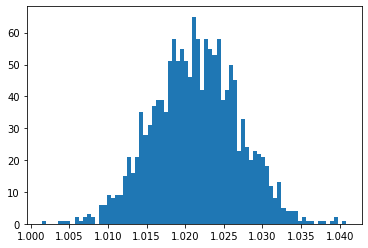

In [33]:
# sigmae

import seaborn as sns

plt.hist( sigmae_store[burnin:maxiter,:], bins = int( (maxiter - burnin + 1)/20) )
plt.show()

In [34]:
np.mean( (sigmae_store[burnin:maxiter].mean() - 1) ** 2)

0.00045812807725694046